<a href="https://colab.research.google.com/github/LikaOkudzhava/BrainyScan/blob/twinkle/Alzheimer_misclassified_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/Xception.model')


In [ ]:
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
import zipfile
from google.colab import drive

gdrive = '/content/drive'
drive.mount(gdrive, force_remount=False)

gdisk = os.path.join(gdrive, 'MyDrive')

filename = 'Copy of preprocessed (1)'

archive_path = os.path.join(gdisk, filename)
with zipfile.ZipFile('/content/drive/MyDrive/Copy of preprocessed (1).zip', 'r') as zip_ref:
 zip_ref.extractall(f'{filename}_extracted')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

dataset_dir = '/content/Copy of preprocessed (1)_extracted/data/Preprocessed'
image_size = (299, 299)
batch_size = 32


datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input,horizontal_flip=True)

test_generator = datagen.flow_from_directory(os.path.join(dataset_dir, 'test'),target_size=image_size,batch_size=batch_size,
    class_mode='categorical',shuffle=False)




Found 6600 images belonging to 4 classes.


In [ ]:
y_true =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions,axis=1)

207/207 ━━━━━━━━━━━━━━━━━━━━ 56s 271ms/step


In [ ]:
filepaths = test_generator.filepaths
class_names = list(test_generator.class_indices.keys())


In [ ]:
misclassified = []

for i in range(len(y_true)):
    if y_pred[i] != y_true[i]:
        misclassified.append((filepaths[i], y_true[i], y_pred[i]))


In [ ]:
misclassified_indices = np.where(y_pred != y_true)[0]
print(f"Total misclassified images: {len(misclassified_indices)}")


Total misclassified images: 33


Identify Misclassified Images

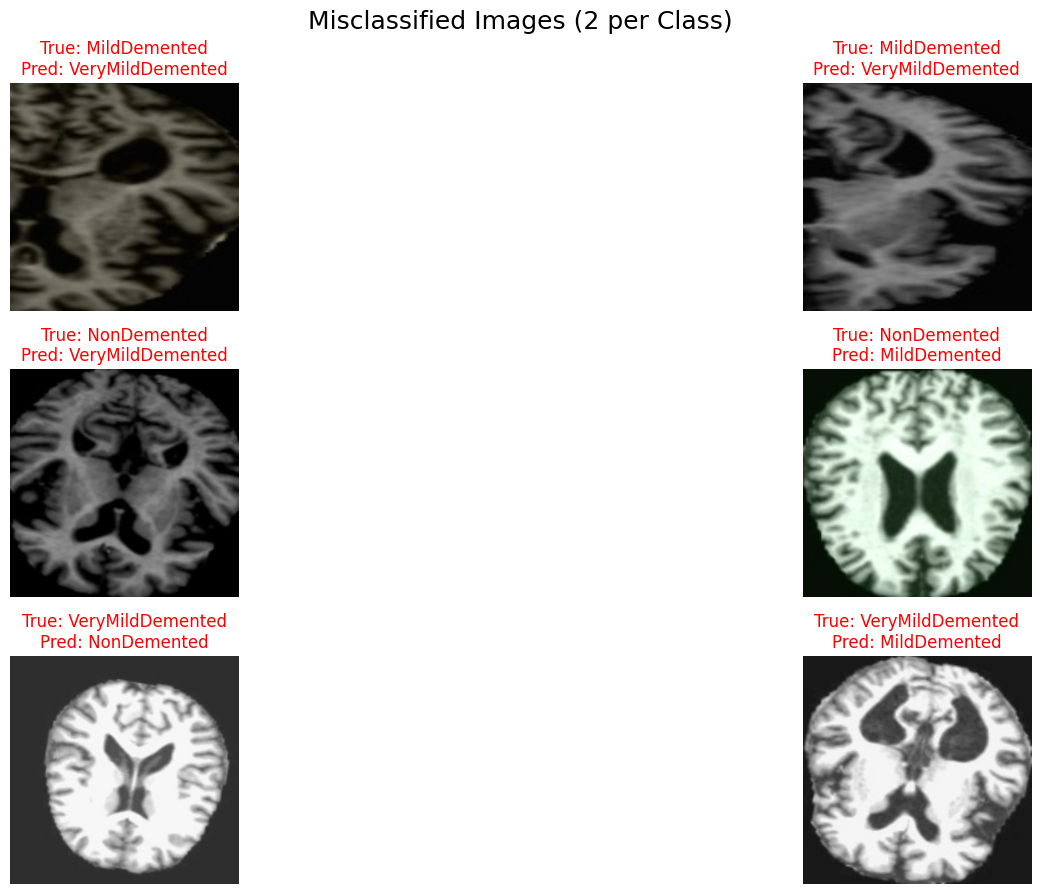

In [ ]:
max_per_class = 2
shown_per_class = {}

plt.figure(figsize=(16, 12))
index = 1

for path, true_label, predicted_label in misclassified:

    if true_label not in shown_per_class:
        shown_per_class[true_label] = 0

    if shown_per_class[true_label] < max_per_class:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(4, max_per_class, index)
        plt.imshow(img)
        plt.title(f"True: {class_names[true_label]}\nPred: {class_names[predicted_label]}", color='red')
        plt.axis('off')

        shown_per_class[true_label] += 1
        index += 1

plt.suptitle("Misclassified Images (2 per Class)", fontsize=18)
plt.tight_layout()
plt.show()


In [ ]:
output_dir = '/content/drive/MyDrive/misclassified_images'
os.makedirs(output_dir, exist_ok=True)

font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.3
font_thickness = 1
text_color = (0, 0, 0)

margin_height = 30

for path, true_label, predicted_label in misclassified:
    img = cv2.imread(path)
    height, width = img.shape[:2]

    #  extra space below
    new_img = np.full((height + margin_height, width, 3), 255, dtype=np.uint8)
    new_img[0:height, 0:width] = img


    true_class = class_names[true_label]
    pred_class = class_names[predicted_label]
    text = f"True: {true_class} | Pred: {pred_class}"

    (text_width, text_height), _ = cv2.getTextSize(text, font, font_scale, font_thickness)
    text_x = max((width - text_width) // 2, 5)
    text_y = height + text_height + 2


    cv2.putText(new_img, text, (text_x, text_y), font, font_scale, text_color, font_thickness)

    filename = os.path.basename(path)
    save_path = os.path.join(output_dir, filename)
    cv2.imwrite(save_path, new_img)




